In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile
zip_path = '/content/drive/MyDrive/archive (4).zip'
extract_path = '/content/datasetcauli'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [3]:
import os

extract_path = '/content/datasetcauli'  # Same as before

for root, dirs, files in os.walk(extract_path):
    for file in files:
        print(os.path.join(root, file))


/content/datasetcauli/split_60_40/train/Cabbage aphid colony/aug_37.jpg
/content/datasetcauli/split_60_40/train/Cabbage aphid colony/orig_18.jpg
/content/datasetcauli/split_60_40/train/Cabbage aphid colony/orig_33.jpg
/content/datasetcauli/split_60_40/train/Cabbage aphid colony/aug_1.jpg
/content/datasetcauli/split_60_40/train/Cabbage aphid colony/aug_67.jpg
/content/datasetcauli/split_60_40/train/Cabbage aphid colony/orig_90.jpg
/content/datasetcauli/split_60_40/train/Cabbage aphid colony/aug_8.jpg
/content/datasetcauli/split_60_40/train/Cabbage aphid colony/aug_63.jpg
/content/datasetcauli/split_60_40/train/Cabbage aphid colony/aug_23.jpg
/content/datasetcauli/split_60_40/train/Cabbage aphid colony/orig_78.jpg
/content/datasetcauli/split_60_40/train/Cabbage aphid colony/orig_39.jpg
/content/datasetcauli/split_60_40/train/Cabbage aphid colony/orig_8.jpg
/content/datasetcauli/split_60_40/train/Cabbage aphid colony/orig_6.jpg
/content/datasetcauli/split_60_40/train/Cabbage aphid colony/

In [4]:
import os

def print_folder_structure_with_counts(root_dir):
    for dirpath, dirnames, filenames in os.walk(root_dir):
        level = dirpath.replace(root_dir, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(dirpath)}/ ({len(filenames)} files)")

extract_path = '/content/datasetcauli'

print_folder_structure_with_counts(extract_path)


datasetcauli/ (0 files)
    split_60_40/ (0 files)
        train/ (0 files)
            Cabbage aphid colony/ (120 files)
            ring spot/ (120 files)
            Bacterial spot rot/ (120 files)
            No disease/ (120 files)
            club root/ (120 files)
            Alternaria_Leaf_Spot/ (120 files)
            Downy Mildew/ (120 files)
            Black Rot/ (120 files)
        test/ (0 files)
            Cabbage aphid colony/ (80 files)
            ring spot/ (80 files)
            Bacterial spot rot/ (80 files)
            No disease/ (80 files)
            club root/ (80 files)
            Alternaria_Leaf_Spot/ (80 files)
            Downy Mildew/ (80 files)
            Black Rot/ (80 files)
    split_70_30/ (0 files)
        train/ (0 files)
            Cabbage aphid colony/ (140 files)
            ring spot/ (140 files)
            Bacterial spot rot/ (140 files)
            No disease/ (140 files)
            club root/ (140 files)
            Alternaria_Leaf_Sp

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras import layers, models
import os
import numpy as np
from sklearn.metrics import f1_score

# === 1. Define Dataset Paths ===
base_dir = "/content/datasetcauli/split_50_50"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "test")  # still used for validation/testing

# === 2. Parameters ===
IMAGE_SIZE = (224, 224)  # DenseNet expects 224x224
BATCH_SIZE = 32
NUM_CLASSES = 8  # Adjust if needed

# === 3. Data Augmentation & Preprocessing ===
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# === 4. Load Pretrained DenseNet201 (no top) ===
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=IMAGE_SIZE + (3,))
base_model.trainable = False  # Freeze base

# === 5. Custom Top Layers ===
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# === 6. Compile Model ===
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# === 7. F1 Score Callback ===
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_preds = []
        val_trues = []
        for i in range(len(val_generator)):
            x_val, y_val = val_generator[i]
            preds = model.predict(x_val)
            val_preds.extend(np.argmax(preds, axis=1))
            val_trues.extend(np.argmax(y_val, axis=1))
        f1 = f1_score(val_trues, val_preds, average='weighted')
        print(f" — val_f1: {f1:.4f}")

# === 8. Train the Model ===
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[F1ScoreCallback()]
)

Found 800 images belonging to 8 classes.
Found 800 images belonging to 8 classes.
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
 — val_f1: 0.88

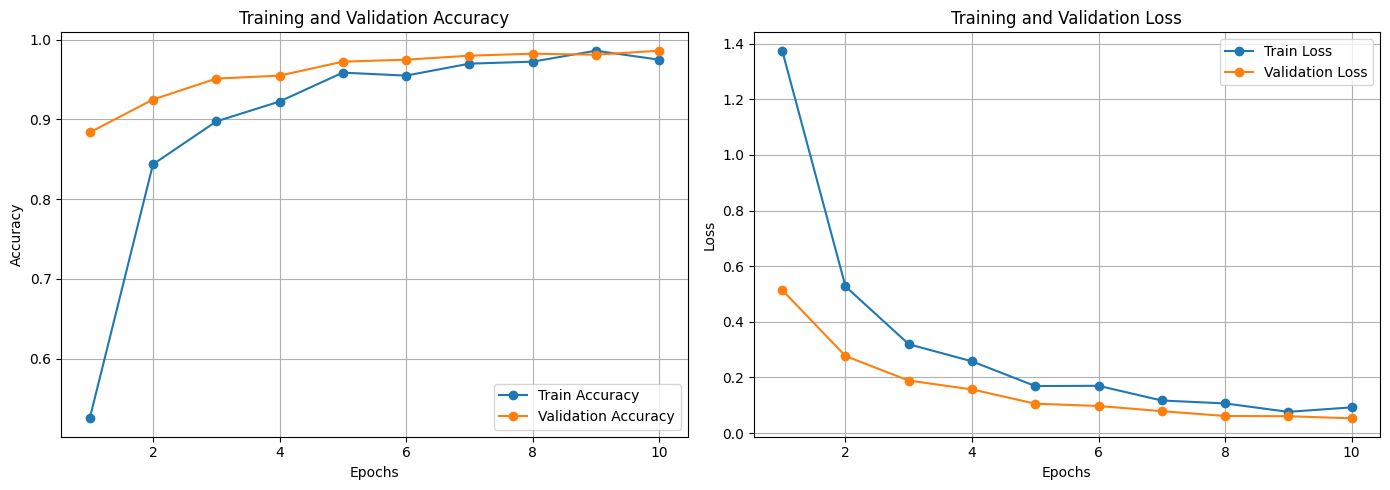

In [10]:
import matplotlib.pyplot as plt

# Extract values from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# 📈 Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# 📉 Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step


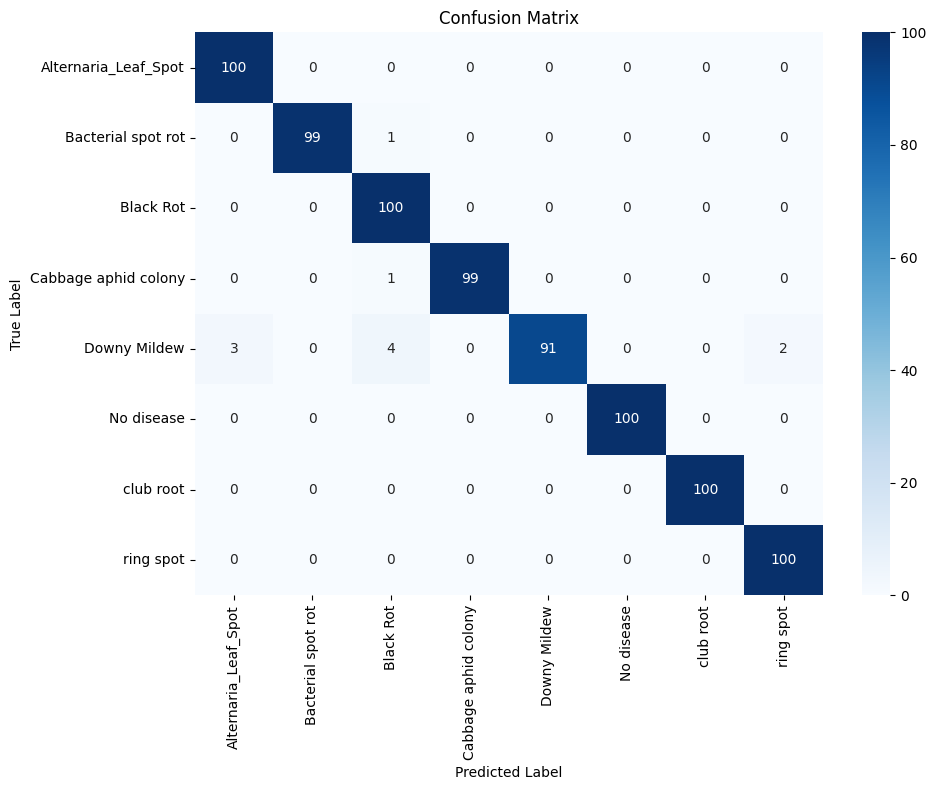


🧾 Classification Report:
                      precision    recall  f1-score   support

Alternaria_Leaf_Spot       0.97      1.00      0.99       100
  Bacterial spot rot       1.00      0.99      0.99       100
           Black Rot       0.94      1.00      0.97       100
Cabbage aphid colony       1.00      0.99      0.99       100
        Downy Mildew       1.00      0.91      0.95       100
          No disease       1.00      1.00      1.00       100
           club root       1.00      1.00      1.00       100
           ring spot       0.98      1.00      0.99       100

            accuracy                           0.99       800
           macro avg       0.99      0.99      0.99       800
        weighted avg       0.99      0.99      0.99       800



In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === Get Predictions ===
y_pred_probs = model.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# === Classification Report ===
print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


In [12]:
# Print per-class confusion matrix stats
print("\n📊 Per-Class Confusion Matrix Stats:")
for i, class_name in enumerate(class_labels):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    print(f"\nClass '{class_name}':")
    print(f"  ✅ True Positives (TP):  {TP}")
    print(f"  ❌ False Positives (FP): {FP}")
    print(f"  ❌ False Negatives (FN): {FN}")
    print(f"  ✅ True Negatives (TN):  {TN}")
    print(f"  🔁 Confusion Pair (TP FN): {TP} {FN}")



📊 Per-Class Confusion Matrix Stats:

Class 'Alternaria_Leaf_Spot':
  ✅ True Positives (TP):  100
  ❌ False Positives (FP): 3
  ❌ False Negatives (FN): 0
  ✅ True Negatives (TN):  697
  🔁 Confusion Pair (TP FN): 100 0

Class 'Bacterial spot rot':
  ✅ True Positives (TP):  99
  ❌ False Positives (FP): 0
  ❌ False Negatives (FN): 1
  ✅ True Negatives (TN):  700
  🔁 Confusion Pair (TP FN): 99 1

Class 'Black Rot':
  ✅ True Positives (TP):  100
  ❌ False Positives (FP): 6
  ❌ False Negatives (FN): 0
  ✅ True Negatives (TN):  694
  🔁 Confusion Pair (TP FN): 100 0

Class 'Cabbage aphid colony':
  ✅ True Positives (TP):  99
  ❌ False Positives (FP): 0
  ❌ False Negatives (FN): 1
  ✅ True Negatives (TN):  700
  🔁 Confusion Pair (TP FN): 99 1

Class 'Downy Mildew':
  ✅ True Positives (TP):  91
  ❌ False Positives (FP): 0
  ❌ False Negatives (FN): 9
  ✅ True Negatives (TN):  700
  🔁 Confusion Pair (TP FN): 91 9

Class 'No disease':
  ✅ True Positives (TP):  100
  ❌ False Positives (FP): 0
  ❌ Fa

In [13]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input  # ✅ Update to match your model (DenseNet201)

# ✅ Get class labels from the validation generator
class_labels = list(val_generator.class_indices.keys())

# ✅ Collect image paths and their true class labels
image_paths_labels = []
for class_name in os.listdir(val_generator.directory):
    class_path = os.path.join(val_generator.directory, class_name)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths_labels.append((os.path.join(class_path, fname), class_name))

# ✅ Randomly sample 10 images
samples = random.sample(image_paths_labels, 10)

# ✅ Plotting predictions
plt.figure(figsize=(20, 10))
for idx, (img_path, true_class) in enumerate(samples):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))  # ✅ Update for DenseNet201 input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Predict
    preds = model.predict(img_array)
    pred_index = np.argmax(preds)
    pred_class = class_labels[pred_index]
    confidence = preds[0][pred_index] * 100

    # Display
    plt.subplot(2, 5, idx + 1)
    plt.imshow(img)
    plt.axis('off')
    color = 'green' if pred_class == true_class else 'red'
    title = f"Actual: {true_class}\nClassify: {pred_class} ({confidence:.1f}%)"
    plt.title(title, fontsize=12, color=color, fontweight='bold')

plt.tight_layout()
plt.suptitle("🔍 Actual vs Classified Cauliflower Disease (Random 10 Samples)", fontsize=20, fontweight='bold', y=1.05)
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

# ✅ Class labels from validation generator
class_labels = list(val_generator.class_indices.keys())

# ✅ Function to predict and visualize one image
def predict_single_image(img_path, model, class_labels):
    try:
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(299, 299))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Make prediction
        preds = model.predict(img_array)
        predicted_index = np.argmax(preds)
        predicted_class = class_labels[predicted_index]
        confidence = preds[0][predicted_index]

        # Show image and prediction
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {predicted_class} ({confidence*100:.2f}%)")
        plt.show()

        print(f"✅ Predicted class: {predicted_class}")
        print(f"📊 Confidence: {confidence * 100:.2f}%")

    except Exception as e:
        print(f"❌ Error loading or processing image: {e}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


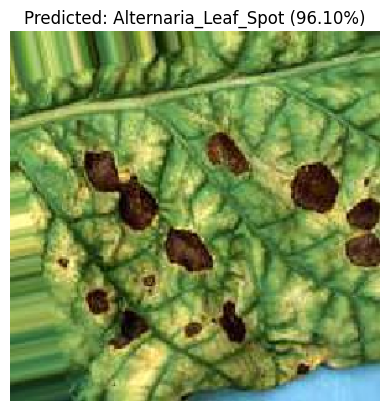

✅ Predicted class: Alternaria_Leaf_Spot
📊 Confidence: 96.10%


In [17]:
# 🔍 Run prediction on a test image
predict_single_image(
    "/content/datasetcauli/split_50_50/test/Alternaria_Leaf_Spot/aug_17.jpg",  # Update path to your image
    model,
    class_labels
)

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# === 1. Final Training & Validation Accuracy from History ===
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(" === Final Accuracy Summary ===")
print(f"Training Accuracy   : {final_train_acc * 100:.2f}%")
print(f"Validation Accuracy : {final_val_acc * 100:.2f}%")

# === 2. Predictions on Test (Validation) Set ===
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# === 3. Final Metrics ===
test_accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\n === Final Test Evaluation Metrics ===")
print(f"Test Accuracy       : {test_accuracy * 100:.2f}%")
print(f"Precision           : {precision * 100:.2f}%")
print(f"Recall              : {recall * 100:.2f}%")
print(f"F1 Score            : {f1 * 100:.2f}%")


 === Final Accuracy Summary ===
Training Accuracy   : 97.50%
Validation Accuracy : 98.62%

 === Final Test Evaluation Metrics ===
Test Accuracy       : 98.62%
Precision           : 98.68%
Recall              : 98.62%
F1 Score            : 98.61%


In [19]:
# Save the trained model
model.save("densenet5050.h5")
print("✅ Model saved as densenet5050.h5")

✅ Model saved as densenet5050.h5


**CAULI6040**

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras import layers, models
import os
import numpy as np
from sklearn.metrics import f1_score

# === 1. Define Dataset Paths ===
base_dir = "/content/datasetcauli/split_60_40"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "test")  # still used for validation/testing

# === 2. Parameters ===
IMAGE_SIZE = (224, 224)  # DenseNet expects 224x224
BATCH_SIZE = 32
NUM_CLASSES = 8  # Adjust if needed

# === 3. Data Augmentation & Preprocessing ===
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# === 4. Load Pretrained DenseNet201 (no top) ===
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=IMAGE_SIZE + (3,))
base_model.trainable = False  # Freeze base

# === 5. Custom Top Layers ===
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# === 6. Compile Model ===
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# === 7. F1 Score Callback ===
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_preds = []
        val_trues = []
        for i in range(len(val_generator)):
            x_val, y_val = val_generator[i]
            preds = model.predict(x_val)
            val_preds.extend(np.argmax(preds, axis=1))
            val_trues.extend(np.argmax(y_val, axis=1))
        f1 = f1_score(val_trues, val_preds, average='weighted')
        print(f" — val_f1: {f1:.4f}")

# === 8. Train the Model ===
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[F1ScoreCallback()]
)

Found 960 images belonging to 8 classes.
Found 640 images belonging to 8 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
 — val_f1: 0.8552
30/30 ━━━━━━━━━━━━━━━━━━━━ 213s 5s/step - accuracy: 0.4114 - loss: 1.7255 - precision: 0.5253 - recall: 0.2546 - val_accuracy: 0.8562 - val_loss: 0.4749 - val_precision: 0.9314 - val_recall: 0

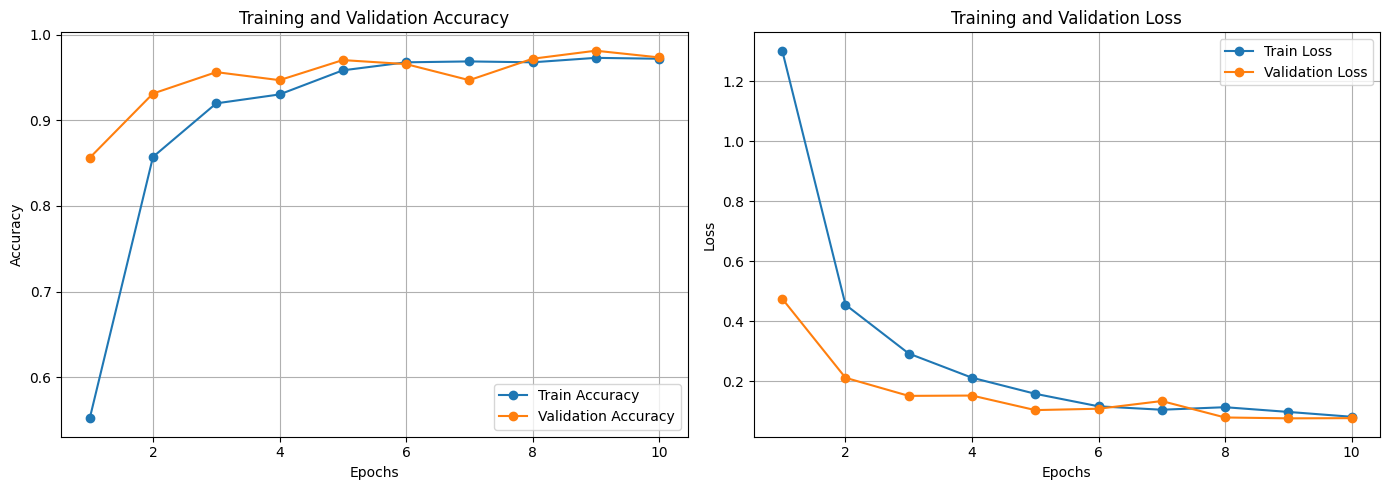

In [21]:
import matplotlib.pyplot as plt

# Extract values from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# 📈 Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# 📉 Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step


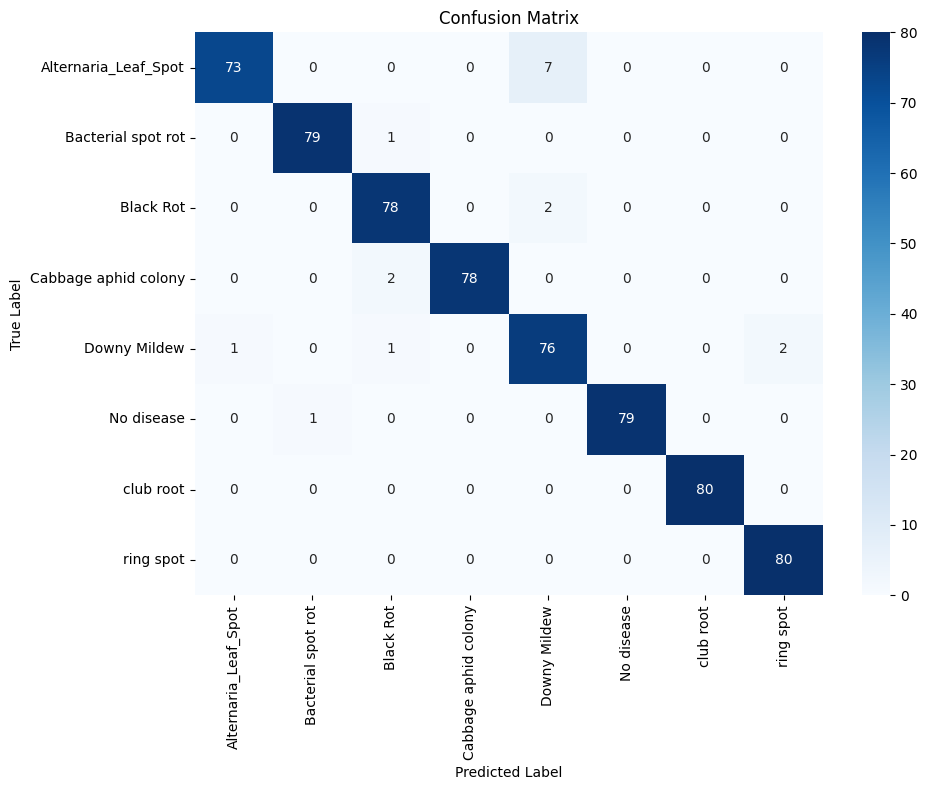


🧾 Classification Report:
                      precision    recall  f1-score   support

Alternaria_Leaf_Spot       0.99      0.91      0.95        80
  Bacterial spot rot       0.99      0.99      0.99        80
           Black Rot       0.95      0.97      0.96        80
Cabbage aphid colony       1.00      0.97      0.99        80
        Downy Mildew       0.89      0.95      0.92        80
          No disease       1.00      0.99      0.99        80
           club root       1.00      1.00      1.00        80
           ring spot       0.98      1.00      0.99        80

            accuracy                           0.97       640
           macro avg       0.97      0.97      0.97       640
        weighted avg       0.97      0.97      0.97       640



In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === Get Predictions ===
y_pred_probs = model.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# === Classification Report ===
print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


In [23]:
# Print per-class confusion matrix stats
print("\n📊 Per-Class Confusion Matrix Stats:")
for i, class_name in enumerate(class_labels):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    print(f"\nClass '{class_name}':")
    print(f"  ✅ True Positives (TP):  {TP}")
    print(f"  ❌ False Positives (FP): {FP}")
    print(f"  ❌ False Negatives (FN): {FN}")
    print(f"  ✅ True Negatives (TN):  {TN}")
    print(f"  🔁 Confusion Pair (TP FN): {TP} {FN}")



📊 Per-Class Confusion Matrix Stats:

Class 'Alternaria_Leaf_Spot':
  ✅ True Positives (TP):  73
  ❌ False Positives (FP): 1
  ❌ False Negatives (FN): 7
  ✅ True Negatives (TN):  559
  🔁 Confusion Pair (TP FN): 73 7

Class 'Bacterial spot rot':
  ✅ True Positives (TP):  79
  ❌ False Positives (FP): 1
  ❌ False Negatives (FN): 1
  ✅ True Negatives (TN):  559
  🔁 Confusion Pair (TP FN): 79 1

Class 'Black Rot':
  ✅ True Positives (TP):  78
  ❌ False Positives (FP): 4
  ❌ False Negatives (FN): 2
  ✅ True Negatives (TN):  556
  🔁 Confusion Pair (TP FN): 78 2

Class 'Cabbage aphid colony':
  ✅ True Positives (TP):  78
  ❌ False Positives (FP): 0
  ❌ False Negatives (FN): 2
  ✅ True Negatives (TN):  560
  🔁 Confusion Pair (TP FN): 78 2

Class 'Downy Mildew':
  ✅ True Positives (TP):  76
  ❌ False Positives (FP): 9
  ❌ False Negatives (FN): 4
  ✅ True Negatives (TN):  551
  🔁 Confusion Pair (TP FN): 76 4

Class 'No disease':
  ✅ True Positives (TP):  79
  ❌ False Positives (FP): 0
  ❌ False N

In [24]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input  # ✅ Update to match your model (DenseNet201)

# ✅ Get class labels from the validation generator
class_labels = list(val_generator.class_indices.keys())

# ✅ Collect image paths and their true class labels
image_paths_labels = []
for class_name in os.listdir(val_generator.directory):
    class_path = os.path.join(val_generator.directory, class_name)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths_labels.append((os.path.join(class_path, fname), class_name))

# ✅ Randomly sample 10 images
samples = random.sample(image_paths_labels, 10)

# ✅ Plotting predictions
plt.figure(figsize=(20, 10))
for idx, (img_path, true_class) in enumerate(samples):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))  # ✅ Update for DenseNet201 input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Predict
    preds = model.predict(img_array)
    pred_index = np.argmax(preds)
    pred_class = class_labels[pred_index]
    confidence = preds[0][pred_index] * 100

    # Display
    plt.subplot(2, 5, idx + 1)
    plt.imshow(img)
    plt.axis('off')
    color = 'green' if pred_class == true_class else 'red'
    title = f"Actual: {true_class}\nClassify: {pred_class} ({confidence:.1f}%)"
    plt.title(title, fontsize=12, color=color, fontweight='bold')

plt.tight_layout()
plt.suptitle("🔍 Actual vs Classified Cauliflower Disease (Random 10 Samples)", fontsize=20, fontweight='bold', y=1.05)
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

# ✅ Class labels from validation generator
class_labels = list(val_generator.class_indices.keys())

# ✅ Function to predict and visualize one image
def predict_single_image(img_path, model, class_labels):
    try:
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(299, 299))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Make prediction
        preds = model.predict(img_array)
        predicted_index = np.argmax(preds)
        predicted_class = class_labels[predicted_index]
        confidence = preds[0][predicted_index]

        # Show image and prediction
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {predicted_class} ({confidence*100:.2f}%)")
        plt.show()

        print(f"✅ Predicted class: {predicted_class}")
        print(f"📊 Confidence: {confidence * 100:.2f}%")

    except Exception as e:
        print(f"❌ Error loading or processing image: {e}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step


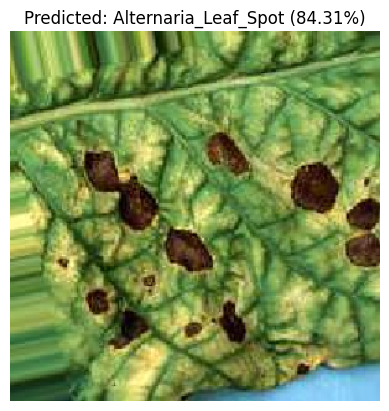

✅ Predicted class: Alternaria_Leaf_Spot
📊 Confidence: 84.31%


In [26]:
# 🔍 Run prediction on a test image
predict_single_image(
    "/content/datasetcauli/split_50_50/test/Alternaria_Leaf_Spot/aug_17.jpg",  # Update path to your image
    model,
    class_labels
)

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# === 1. Final Training & Validation Accuracy from History ===
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(" === Final Accuracy Summary ===")
print(f"Training Accuracy   : {final_train_acc * 100:.2f}%")
print(f"Validation Accuracy : {final_val_acc * 100:.2f}%")

# === 2. Predictions on Test (Validation) Set ===
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# === 3. Final Metrics ===
test_accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\n === Final Test Evaluation Metrics ===")
print(f"Test Accuracy       : {test_accuracy * 100:.2f}%")
print(f"Precision           : {precision :.2f}")
print(f"Recall              : {recall :.2f}")
print(f"F1 Score            : {f1 :.2f}")


 === Final Accuracy Summary ===
Training Accuracy   : 98.20%
Validation Accuracy : 97.50%

 === Final Test Evaluation Metrics ===
Test Accuracy       : 97.50%
Precision           : 0.98
Recall              : 0.97
F1 Score            : 0.98


In [30]:
# Save the trained model
model.save("densenet6040.h5")
print("✅ Model saved as densenet6040.h5")

✅ Model saved as densenet6040.h5


**CAULI7030**

In [29]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras import layers, models
import os
import numpy as np
from sklearn.metrics import f1_score

# === 1. Define Dataset Paths ===
base_dir = "/content/datasetcauli/split_70_30"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "test")  # still used for validation/testing

# === 2. Parameters ===
IMAGE_SIZE = (224, 224)  # DenseNet expects 224x224
BATCH_SIZE = 32
NUM_CLASSES = 8  # Adjust if needed

# === 3. Data Augmentation & Preprocessing ===
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# === 4. Load Pretrained DenseNet201 (no top) ===
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=IMAGE_SIZE + (3,))
base_model.trainable = False  # Freeze base

# === 5. Custom Top Layers ===
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# === 6. Compile Model ===
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# === 7. F1 Score Callback ===
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_preds = []
        val_trues = []
        for i in range(len(val_generator)):
            x_val, y_val = val_generator[i]
            preds = model.predict(x_val)
            val_preds.extend(np.argmax(preds, axis=1))
            val_trues.extend(np.argmax(y_val, axis=1))
        f1 = f1_score(val_trues, val_preds, average='weighted')
        print(f" — val_f1: {f1:.4f}")

# === 8. Train the Model ===
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[F1ScoreCallback()]
)

Found 1120 images belonging to 8 classes.
Found 480 images belonging to 8 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
 — val_f1: 0.9093
35/35 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.4402 - loss: 1.6600 - precision: 0.5896 - recall: 0.2702 - val_accuracy: 0.9104 - val_loss: 0.3321 - val_precision: 0.9495 - val_recall: 0.8625
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━

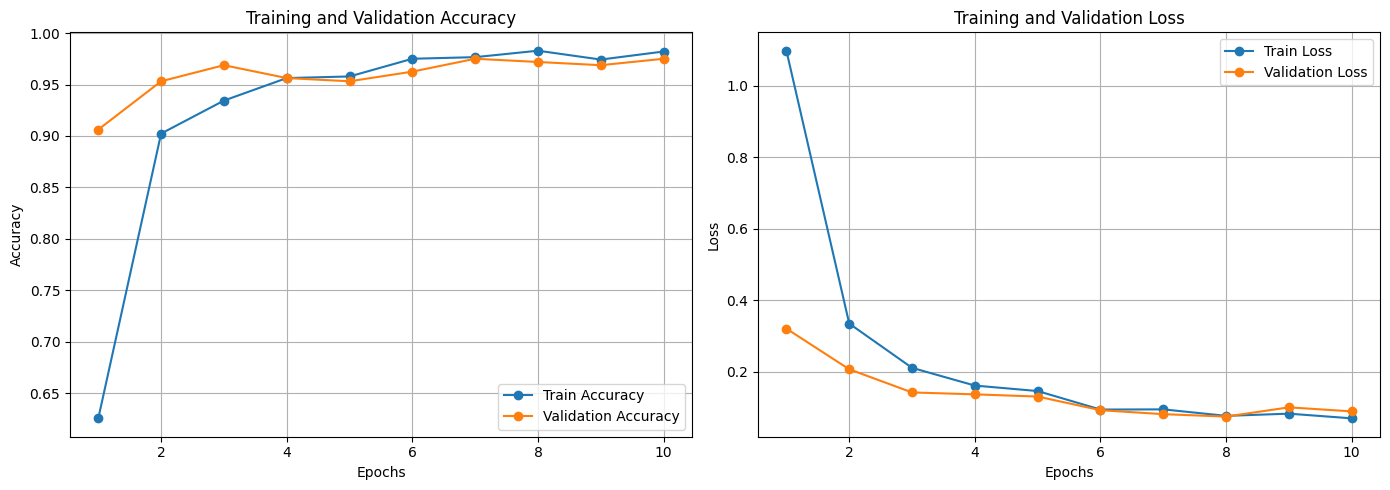

In [6]:
import matplotlib.pyplot as plt

# Extract values from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# 📈 Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# 📉 Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 99s 9s/step


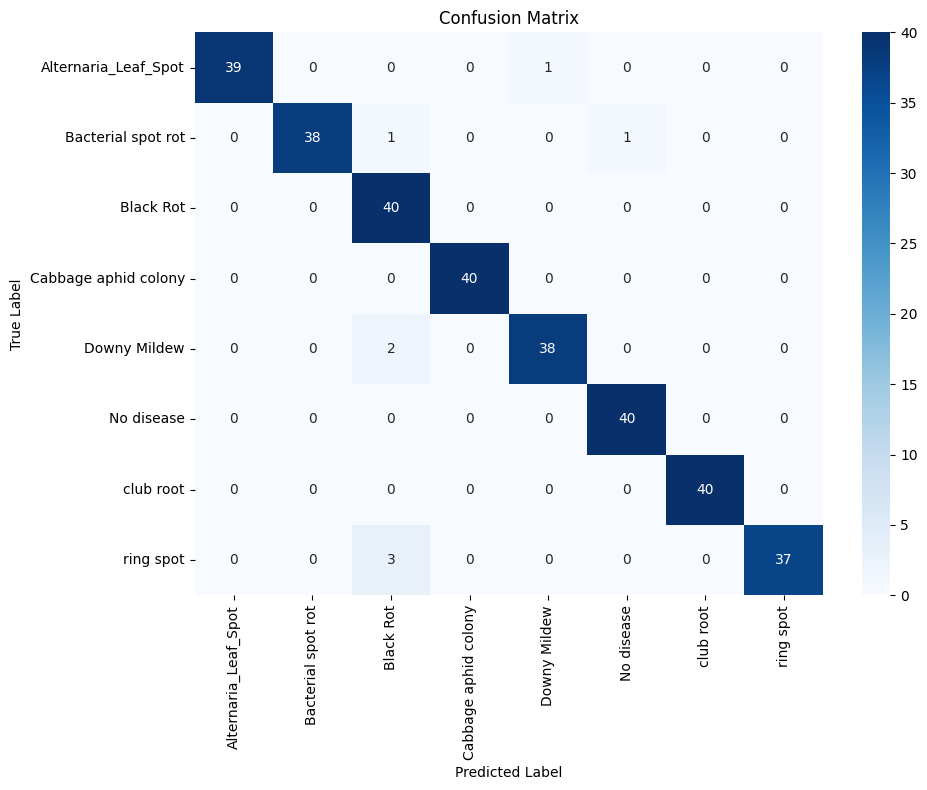


🧾 Classification Report:
                      precision    recall  f1-score   support

Alternaria_Leaf_Spot       1.00      0.97      0.99        40
  Bacterial spot rot       1.00      0.95      0.97        40
           Black Rot       0.87      1.00      0.93        40
Cabbage aphid colony       1.00      1.00      1.00        40
        Downy Mildew       0.97      0.95      0.96        40
          No disease       0.98      1.00      0.99        40
           club root       1.00      1.00      1.00        40
           ring spot       1.00      0.93      0.96        40

            accuracy                           0.97       320
           macro avg       0.98      0.97      0.98       320
        weighted avg       0.98      0.97      0.98       320



In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === Get Predictions ===
y_pred_probs = model.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# === Classification Report ===
print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


In [8]:
# Print per-class confusion matrix stats
print("\n📊 Per-Class Confusion Matrix Stats:")
for i, class_name in enumerate(class_labels):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    print(f"\nClass '{class_name}':")
    print(f"  ✅ True Positives (TP):  {TP}")
    print(f"  ❌ False Positives (FP): {FP}")
    print(f"  ❌ False Negatives (FN): {FN}")
    print(f"  ✅ True Negatives (TN):  {TN}")
    print(f"  🔁 Confusion Pair (TP FN): {TP} {FN}")



📊 Per-Class Confusion Matrix Stats:

Class 'Alternaria_Leaf_Spot':
  ✅ True Positives (TP):  39
  ❌ False Positives (FP): 0
  ❌ False Negatives (FN): 1
  ✅ True Negatives (TN):  280
  🔁 Confusion Pair (TP FN): 39 1

Class 'Bacterial spot rot':
  ✅ True Positives (TP):  38
  ❌ False Positives (FP): 0
  ❌ False Negatives (FN): 2
  ✅ True Negatives (TN):  280
  🔁 Confusion Pair (TP FN): 38 2

Class 'Black Rot':
  ✅ True Positives (TP):  40
  ❌ False Positives (FP): 6
  ❌ False Negatives (FN): 0
  ✅ True Negatives (TN):  274
  🔁 Confusion Pair (TP FN): 40 0

Class 'Cabbage aphid colony':
  ✅ True Positives (TP):  40
  ❌ False Positives (FP): 0
  ❌ False Negatives (FN): 0
  ✅ True Negatives (TN):  280
  🔁 Confusion Pair (TP FN): 40 0

Class 'Downy Mildew':
  ✅ True Positives (TP):  38
  ❌ False Positives (FP): 1
  ❌ False Negatives (FN): 2
  ✅ True Negatives (TN):  279
  🔁 Confusion Pair (TP FN): 38 2

Class 'No disease':
  ✅ True Positives (TP):  40
  ❌ False Positives (FP): 1
  ❌ False N

In [9]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input  # ✅ Update to match your model (DenseNet201)

# ✅ Get class labels from the validation generator
class_labels = list(val_generator.class_indices.keys())

# ✅ Collect image paths and their true class labels
image_paths_labels = []
for class_name in os.listdir(val_generator.directory):
    class_path = os.path.join(val_generator.directory, class_name)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths_labels.append((os.path.join(class_path, fname), class_name))

# ✅ Randomly sample 10 images
samples = random.sample(image_paths_labels, 10)

# ✅ Plotting predictions
plt.figure(figsize=(20, 10))
for idx, (img_path, true_class) in enumerate(samples):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))  # ✅ Update for DenseNet201 input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Predict
    preds = model.predict(img_array)
    pred_index = np.argmax(preds)
    pred_class = class_labels[pred_index]
    confidence = preds[0][pred_index] * 100

    # Display
    plt.subplot(2, 5, idx + 1)
    plt.imshow(img)
    plt.axis('off')
    color = 'green' if pred_class == true_class else 'red'
    title = f"Actual: {true_class}\nClassify: {pred_class} ({confidence:.1f}%)"
    plt.title(title, fontsize=12, color=color, fontweight='bold')

plt.tight_layout()
plt.suptitle("🔍 Actual vs Classified Cauliflower Disease (Random 10 Samples)", fontsize=20, fontweight='bold', y=1.05)
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

# ✅ Class labels from validation generator
class_labels = list(val_generator.class_indices.keys())

# ✅ Function to predict and visualize one image
def predict_single_image(img_path, model, class_labels):
    try:
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(299, 299))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Make prediction
        preds = model.predict(img_array)
        predicted_index = np.argmax(preds)
        predicted_class = class_labels[predicted_index]
        confidence = preds[0][predicted_index]

        # Show image and prediction
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {predicted_class} ({confidence*100:.2f}%)")
        plt.show()

        print(f"✅ Predicted class: {predicted_class}")
        print(f"📊 Confidence: {confidence * 100:.2f}%")

    except Exception as e:
        print(f"❌ Error loading or processing image: {e}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step


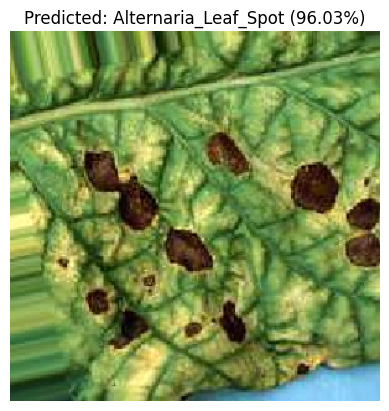

✅ Predicted class: Alternaria_Leaf_Spot
📊 Confidence: 96.03%


In [38]:
# 🔍 Run prediction on a test image
predict_single_image(
    "/content/datasetcauli/split_50_50/test/Alternaria_Leaf_Spot/aug_17.jpg",  # Update path to your image
    model,
    class_labels
)

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# === 1. Final Training & Validation Accuracy from History ===
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(" === Final Accuracy Summary ===")
print(f"Training Accuracy   : {final_train_acc * 100:.2f}%")
print(f"Validation Accuracy : {final_val_acc * 100:.2f}%")

# === 2. Predictions on Test (Validation) Set ===
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# === 3. Final Metrics ===
test_accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\n === Final Test Evaluation Metrics ===")
print(f"Test Accuracy       : {test_accuracy * 100:.2f}%")
print(f"Precision           : {precision :.2f}")
print(f"Recall              : {recall :.2f}")
print(f"F1 Score            : {f1 :.2f}")


 === Final Accuracy Summary ===
Training Accuracy   : 98.20%
Validation Accuracy : 97.50%

 === Final Test Evaluation Metrics ===
Test Accuracy       : 97.50%
Precision           : 0.98
Recall              : 0.97
F1 Score            : 0.98


In [42]:
# Save the trained model
model.save("densenet7031.h5")
print("✅ Model saved as densenet7031.h5")

✅ Model saved as densenet7031.h5


**CAULI8020**

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras import layers, models
import os
import numpy as np
from sklearn.metrics import f1_score

# === 1. Define Dataset Paths ===
base_dir = "/content/datasetcauli/split_80_20"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "test")  # still used for validation/testing

# === 2. Parameters ===
IMAGE_SIZE = (224, 224)  # DenseNet expects 224x224
BATCH_SIZE = 32
NUM_CLASSES = 8  # Adjust if needed

# === 3. Data Augmentation & Preprocessing ===
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# === 4. Load Pretrained DenseNet201 (no top) ===
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=IMAGE_SIZE + (3,))
base_model.trainable = False  # Freeze base

# === 5. Custom Top Layers ===
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# === 6. Compile Model ===
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# === 7. F1 Score Callback ===
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_preds = []
        val_trues = []
        for i in range(len(val_generator)):
            x_val, y_val = val_generator[i]
            preds = model.predict(x_val)
            val_preds.extend(np.argmax(preds, axis=1))
            val_trues.extend(np.argmax(y_val, axis=1))
        f1 = f1_score(val_trues, val_preds, average='weighted')
        print(f" — val_f1: {f1:.4f}")

# === 8. Train the Model ===
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[F1ScoreCallback()]
)

Found 1280 images belonging to 8 classes.
Found 320 images belonging to 8 classes.
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
 — val_f1: 0.9065
40/40 ━━━━━━━━━━━━━━━━━━━━ 671s 16s/step - accuracy: 0.4321 - loss: 1.6674 - precision: 0.6305 - recall: 0.2728 - val_accuracy: 0.9062 - val_loss: 0.3210 - val_precision: 0.9400 - val_recall: 0.8813
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
 — val_f1: 0.9540
40/40 ━━━━━━━━━━━

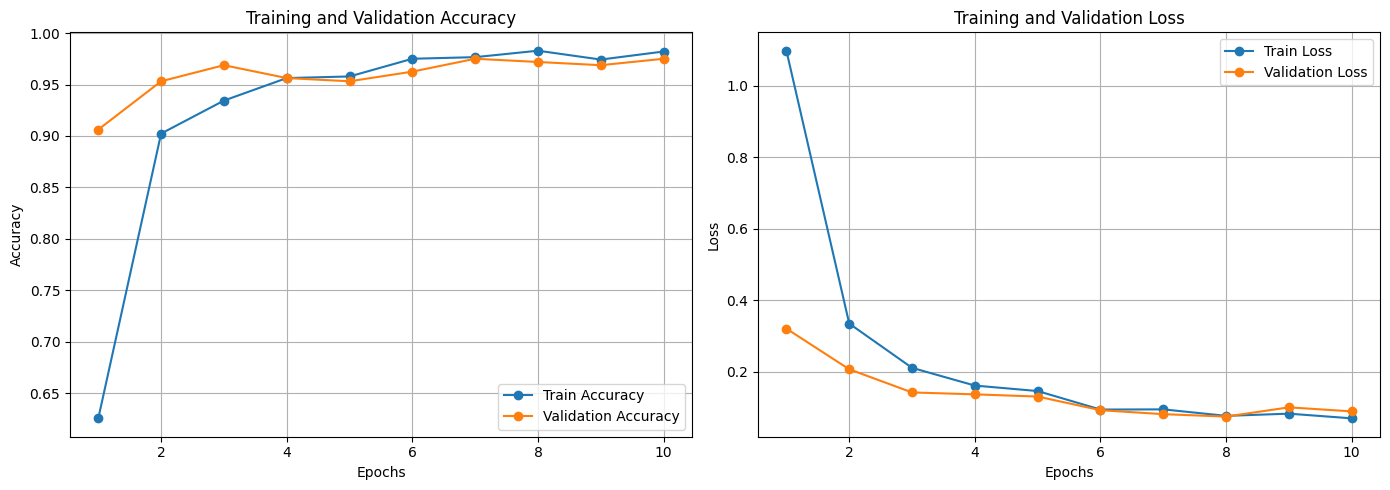

In [12]:
import matplotlib.pyplot as plt

# Extract values from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

# 📈 Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# 📉 Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 91s 9s/step


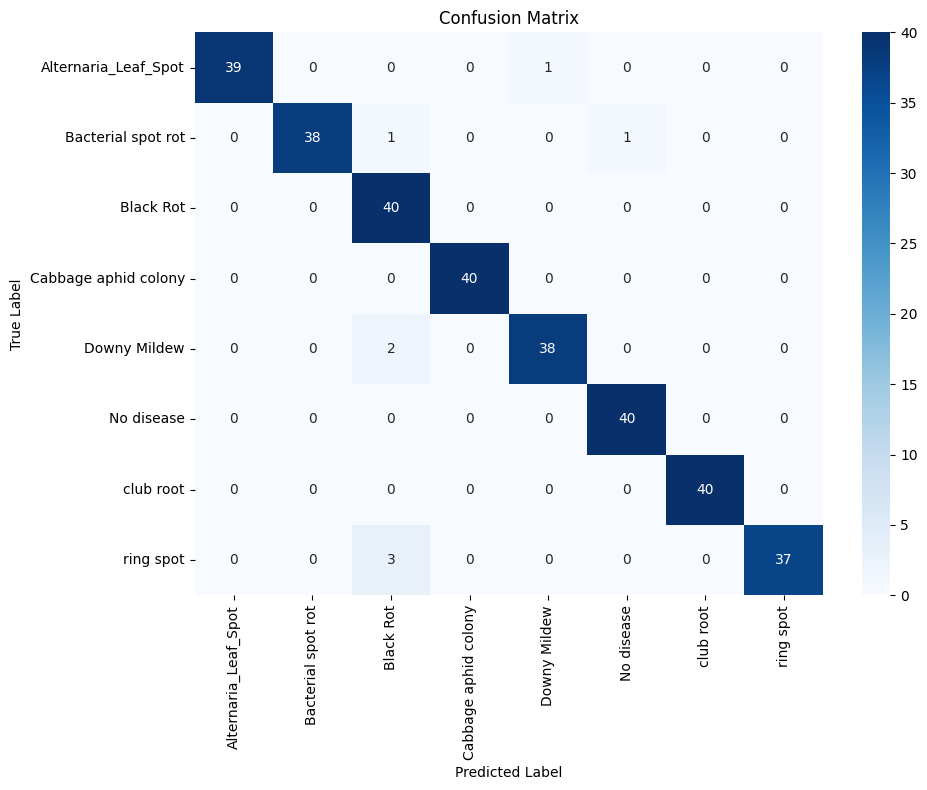


🧾 Classification Report:
                      precision    recall  f1-score   support

Alternaria_Leaf_Spot       1.00      0.97      0.99        40
  Bacterial spot rot       1.00      0.95      0.97        40
           Black Rot       0.87      1.00      0.93        40
Cabbage aphid colony       1.00      1.00      1.00        40
        Downy Mildew       0.97      0.95      0.96        40
          No disease       0.98      1.00      0.99        40
           club root       1.00      1.00      1.00        40
           ring spot       1.00      0.93      0.96        40

            accuracy                           0.97       320
           macro avg       0.98      0.97      0.98       320
        weighted avg       0.98      0.97      0.98       320



In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === Get Predictions ===
y_pred_probs = model.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# === Classification Report ===
print("\n🧾 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


In [14]:
# Print per-class confusion matrix stats
print("\n📊 Per-Class Confusion Matrix Stats:")
for i, class_name in enumerate(class_labels):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    print(f"\nClass '{class_name}':")
    print(f"  ✅ True Positives (TP):  {TP}")
    print(f"  ❌ False Positives (FP): {FP}")
    print(f"  ❌ False Negatives (FN): {FN}")
    print(f"  ✅ True Negatives (TN):  {TN}")
    print(f"  🔁 Confusion Pair (TP FN): {TP} {FN}")



📊 Per-Class Confusion Matrix Stats:

Class 'Alternaria_Leaf_Spot':
  ✅ True Positives (TP):  39
  ❌ False Positives (FP): 0
  ❌ False Negatives (FN): 1
  ✅ True Negatives (TN):  280
  🔁 Confusion Pair (TP FN): 39 1

Class 'Bacterial spot rot':
  ✅ True Positives (TP):  38
  ❌ False Positives (FP): 0
  ❌ False Negatives (FN): 2
  ✅ True Negatives (TN):  280
  🔁 Confusion Pair (TP FN): 38 2

Class 'Black Rot':
  ✅ True Positives (TP):  40
  ❌ False Positives (FP): 6
  ❌ False Negatives (FN): 0
  ✅ True Negatives (TN):  274
  🔁 Confusion Pair (TP FN): 40 0

Class 'Cabbage aphid colony':
  ✅ True Positives (TP):  40
  ❌ False Positives (FP): 0
  ❌ False Negatives (FN): 0
  ✅ True Negatives (TN):  280
  🔁 Confusion Pair (TP FN): 40 0

Class 'Downy Mildew':
  ✅ True Positives (TP):  38
  ❌ False Positives (FP): 1
  ❌ False Negatives (FN): 2
  ✅ True Negatives (TN):  279
  🔁 Confusion Pair (TP FN): 38 2

Class 'No disease':
  ✅ True Positives (TP):  40
  ❌ False Positives (FP): 1
  ❌ False N

In [15]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input  # ✅ Update to match your model (DenseNet201)

# ✅ Get class labels from the validation generator
class_labels = list(val_generator.class_indices.keys())

# ✅ Collect image paths and their true class labels
image_paths_labels = []
for class_name in os.listdir(val_generator.directory):
    class_path = os.path.join(val_generator.directory, class_name)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths_labels.append((os.path.join(class_path, fname), class_name))

# ✅ Randomly sample 10 images
samples = random.sample(image_paths_labels, 10)

# ✅ Plotting predictions
plt.figure(figsize=(20, 10))
for idx, (img_path, true_class) in enumerate(samples):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))  # ✅ Update for DenseNet201 input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Predict
    preds = model.predict(img_array)
    pred_index = np.argmax(preds)
    pred_class = class_labels[pred_index]
    confidence = preds[0][pred_index] * 100

    # Display
    plt.subplot(2, 5, idx + 1)
    plt.imshow(img)
    plt.axis('off')
    color = 'green' if pred_class == true_class else 'red'
    title = f"Actual: {true_class}\nClassify: {pred_class} ({confidence:.1f}%)"
    plt.title(title, fontsize=12, color=color, fontweight='bold')

plt.tight_layout()
plt.suptitle("🔍 Actual vs Classified Cauliflower Disease (Random 10 Samples)", fontsize=20, fontweight='bold', y=1.05)
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

# ✅ Class labels from validation generator
class_labels = list(val_generator.class_indices.keys())

# ✅ Function to predict and visualize one image
def predict_single_image(img_path, model, class_labels):
    try:
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(299, 299))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)

        # Make prediction
        preds = model.predict(img_array)
        predicted_index = np.argmax(preds)
        predicted_class = class_labels[predicted_index]
        confidence = preds[0][predicted_index]

        # Show image and prediction
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {predicted_class} ({confidence*100:.2f}%)")
        plt.show()

        print(f"✅ Predicted class: {predicted_class}")
        print(f"📊 Confidence: {confidence * 100:.2f}%")

    except Exception as e:
        print(f"❌ Error loading or processing image: {e}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


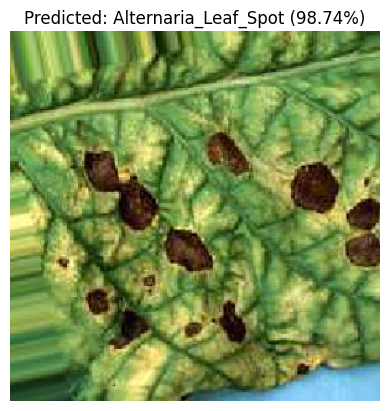

✅ Predicted class: Alternaria_Leaf_Spot
📊 Confidence: 98.74%


In [17]:
# 🔍 Run prediction on a test image
predict_single_image(
    "/content/datasetcauli/split_50_50/test/Alternaria_Leaf_Spot/aug_17.jpg",  # Update path to your image
    model,
    class_labels
)

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# === 1. Final Training & Validation Accuracy from History ===
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(" === Final Accuracy Summary ===")
print(f"Training Accuracy   : {final_train_acc * 100:.2f}%")
print(f"Validation Accuracy : {final_val_acc * 100:.2f}%")

# === 2. Predictions on Test (Validation) Set ===
y_true = val_generator.classes
y_pred_probs = model.predict(val_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# === 3. Final Metrics ===
test_accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\n === Final Test Evaluation Metrics ===")
print(f"Test Accuracy       : {test_accuracy * 100:.2f}%")
print(f"Precision           : {precision :.4f}%")
print(f"Recall              : {recall :.4f}%")
print(f"F1 Score            : {f1 :.4f}%")


 === Final Accuracy Summary ===
Training Accuracy   : 98.20%
Validation Accuracy : 97.50%

 === Final Test Evaluation Metrics ===
Test Accuracy       : 97.50%
Precision           : 0.9774%
Recall              : 0.9750%
F1 Score            : 0.9753%


In [ ]:
# Save the trained model
model.save("densenet8020.h5")
print("✅ Model saved as densenet8020.h5")